In [2]:
import sys
import os
import cv2
import pandas as pd
import torch
import numpy as np
import random
import time
import matplotlib.pyplot as plt
from numpy import pi, matmul,sqrt,dot,array,zeros,cos,sin,pi,arccos,arctan
from func import OR,heatplot,calmisorientation,mat2plot, match,imgshow,calpoint,L2,L1,ipfread,misorientation
from Class import Exp,Data,Cluster,Dataset
import torch.nn.functional as F
import matplotlib.patches as patches
from multiprocessing import Process, Pool
from sklearn.mixture import GaussianMixture
path="data/train/20200923/before/"
data=Data(path+date+"/before/")
orient=data.data["Orient"]
phase=data.data["Phase"]
inv = np.load("new_inv.npy")
h,w=orient.shape[0],orient.shape[1]

1


In [6]:
os.listdir("data/test/")

['20200907', '20201109']

In [3]:
id2clus=dict() 
class_map=np.zeros([h,w]).astype("int") # c-> class #
# 0->martensite, 1->ferrite
clusort=dict()
c=1
t=3
cluster=Cluster(c,0,0)
class_map[0,0]=c
id2clus[class_map[0,0]]=cluster
clusort[c]=orient[0,0]
for i in range(h):#h
    for j in range(w):#w
        if i==0 :
            if j!=w-1:
                if misorientation(orient[i,j],orient[i,j+1],inv)<t:
                    class_map[i,j+1]=class_map[i,j]
                    id2clus[class_map[i,j+1]].add(i,j+1)
                else:
                    c+=1
                    class_map[i,j+1]=c
                    cluster=Cluster(c,i,j+1)
                    id2clus[class_map[i,j+1]]=cluster
                    clusort[c]=orient[i,j+1]
                    id2clus[class_map[i,j+1]].addn(class_map[i,j])
                    id2clus[class_map[i,j]].addn(class_map[i,j+1])
        else:
            if j==0:
                if misorientation(orient[i,j],orient[i-1,j],inv)<t:
                    class_map[i,j]=class_map[i-1,j]
                    id2clus[class_map[i,j]].add(i,j)
                else:
                    c+=1
                    class_map[i,j]=c
                    cluster=Cluster(c,i,j)
                    clusort[c]=orient[i,j]
                    id2clus[class_map[i,j]]=cluster
                    id2clus[class_map[i-1,j]].addn(class_map[i,j])
                    id2clus[class_map[i,j]].addn(class_map[i-1,j])
            else:
                n1=misorientation(orient[i,j],orient[i-1,j],inv)
                n2=misorientation(orient[i,j],orient[i,j-1],inv)
                if n1<n2 and n1<t:
                    class_map[i,j]=class_map[i-1,j]
                    id2clus[class_map[i,j]].add(i,j)
                    if class_map[i,j]!=class_map[i,j-1]:
                        id2clus[class_map[i,j]].addn(class_map[i,j-1])
                        id2clus[class_map[i,j-1]].addn(class_map[i,j])
                elif n2<t:
                    class_map[i,j]=class_map[i,j-1]
                    id2clus[class_map[i,j]].add(i,j)
                    if class_map[i,j]!=class_map[i-1,j]:
                        id2clus[class_map[i,j]].addn(class_map[i-1,j])
                        id2clus[class_map[i-1,j]].addn(class_map[i,j])
                else:
                    c+=1
                    class_map[i,j]=c
                    cluster=Cluster(c,i,j)
                    clusort[c]=orient[i,j]
                    id2clus[class_map[i,j]]=cluster
                    if class_map[i,j]!=class_map[i-1,j]:
                        id2clus[class_map[i,j]].addn(class_map[i-1,j])
                        id2clus[class_map[i-1,j]].addn(class_map[i,j])
                    if class_map[i,j]!=class_map[i,j-1]:
                        id2clus[class_map[i,j]].addn(class_map[i,j-1])
                        id2clus[class_map[i,j-1]].addn(class_map[i,j])                    

12324


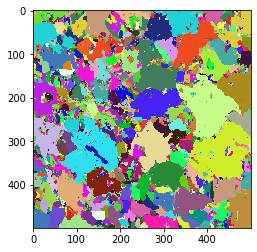

6752


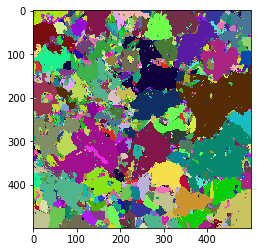

6479


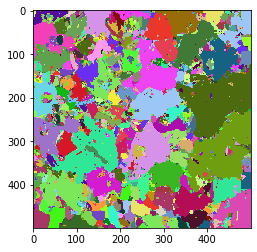

6420


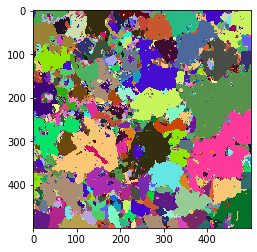

6398


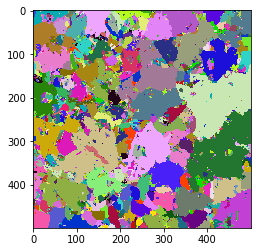

6385


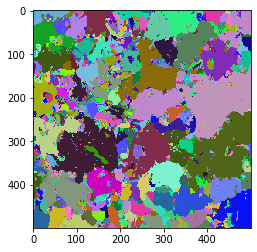

6378


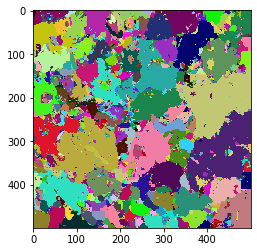

6371


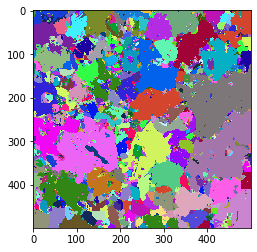

6363


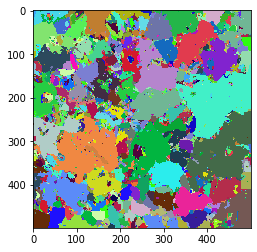

6350


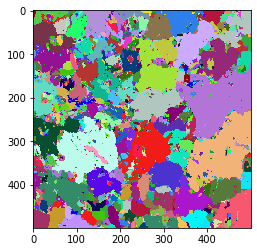

6347


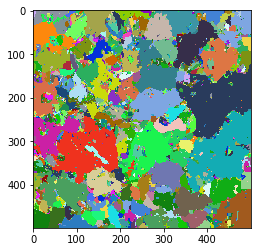

6339


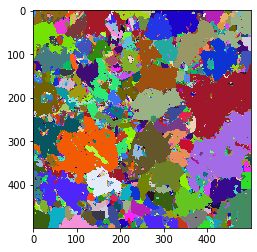

6334


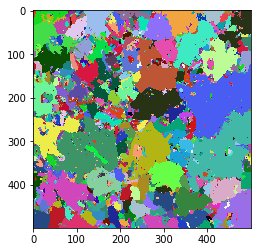

6326


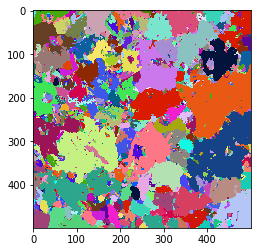

6324


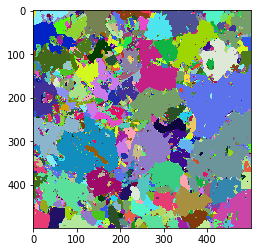

6320


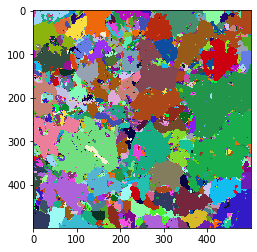

6316


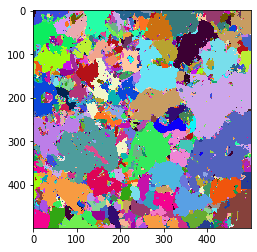

6313


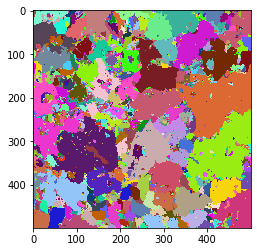

6312


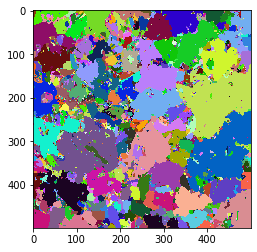

In [15]:
t2=3
prev_len=-1
ite=1
times=3.
while prev_len!=len(id2clus):
    prev_len=len(id2clus)
    ite+=1
    print(prev_len)
    for i in range(1,c+1):
        if i in id2clus:
            for id in id2clus[i].neigh.copy():
                mis_angle=0
                for _ in range(int(times)):
                    i0,j0=random.sample(id2clus[i].pixels,1)[0]
                    if data.data["Phase"][i0,j0]==0:
                        i0,j0=random.sample(id2clus[i].pixels,1)[0]                        
                    i1,j1=random.sample(id2clus[id].pixels,1)[0]
                    if data.data["Phase"][i1,j1]==0:
                        i1,j1=random.sample(id2clus[id].pixels,1)[0]
                    mis_angle+=misorientation(orient[i0,j0],orient[i1,j1],inv)
                mis_angle/=times
                if  mis_angle<t2:
                    for (k,l) in id2clus[id].pixels:
                        class_map[k,l]=i 
                    id2clus[i].merge(id,id2clus)
    if ite>20:
        break


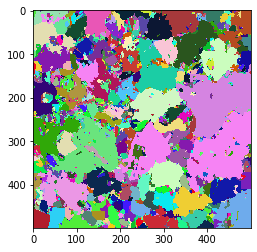

In [17]:
for i in range(1,c+1):
    if i in id2clus:
        if len(id2clus[i].neigh)==1:
            id2clus[i].merge(list(id2clus[i].neigh)[0],id2clus)
            
for id in list(id2clus.keys()):
    for (i,j) in id2clus[id].pixels:
        class_map[i,j]=id                


[[  1.95915106]
 [211.75114967]]


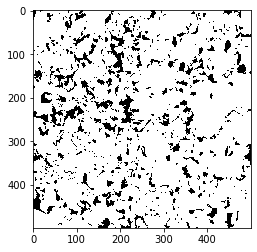

In [18]:
num=[]
for i in range(1,c+1):
    if i in id2clus:
        num.append(id2clus[i].num)
X = np.array(num).reshape(-1,1)
gm = GaussianMixture(n_components=2, random_state=0,tol=1e-5).fit(X)
print(gm.means_)
bd_map=np.zeros([h,w])
for id in list(id2clus.keys()):
    if id2clus[id].num>np.mean(gm.means_):
        for (i,j) in id2clus[id].pixels:
            bd_map[i,j]=1


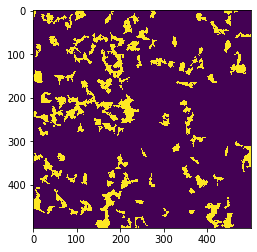

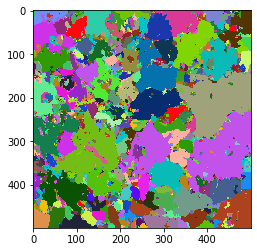

In [19]:
phase=(1-bd_map*data.data["Phase"])
cmap=np.zeros([phase.shape[0],phase.shape[1]]).astype("int")
cluster=dict()
ind = 1
for i in range(phase.shape[0]):
    for j in range(phase.shape[1]):
        if phase[i,j]==1:
            if j>0 and phase[i,j-1]==1:
                cmap[i,j]=cmap[i,j-1]
                cluster[cmap[i,j]].add(i,j)
                if i>0 and phase[i-1,j]==1 and cmap[i,j]!=cmap[i-1,j]:
                    cluster[cmap[i,j]].addn(cmap[i-1,j])
                    cluster[cmap[i-1,j]].addn(cmap[i,j])                    
            elif i>0 and phase[i-1,j]==1:
                cmap[i,j]=cmap[i-1,j]
                cluster[cmap[i,j]].add(i,j)
            else:
                cmap[i,j]=ind
                cluster[ind]=Cluster(ind,i,j)
                ind+=1   
for key in range(1,ind):
    if key in cluster:
        for neigh in cluster[key].neigh.copy():
            cluster[key].merge(neigh,cluster)
phase_aft=np.zeros([phase.shape[0],phase.shape[1]])
for key in range(1,ind):
    if key in cluster:
        if cluster[key].num>np.mean(gm.means_):
            for (i,j) in cluster[key].pixels:
                phase_aft[i,j]=1


In [20]:
ma=set()
for i in range(h):#h
    for j in range(w):#w
        if i==0 :
            if j!=w-1:
                if phase_aft[i,j] and phase_aft[i,j+1] and class_map[i,j]!=class_map[i,j+1]:
                    tomerge=class_map[i,j+1]
                    for (k,l) in id2clus[tomerge].pixels:
                        class_map[k,l]=class_map[i,j]
                    id2clus[class_map[i,j]].merge(tomerge,id2clus)
                    ma.add(class_map[i,j])
                    if tomerge in ma:
                        ma.remove(tomerge)
                    
        else:
            if j==0:
                if phase_aft[i,j] and phase_aft[i-1,j] and class_map[i-1,j]!=class_map[i,j]:
                    tomerge=class_map[i-1,j]
                    for (k,l) in id2clus[tomerge].pixels:
                        class_map[k,l]=class_map[i,j]
                    id2clus[class_map[i,j]].merge(tomerge,id2clus)
                    ma.add(class_map[i,j])
                    if tomerge in ma:
                        ma.remove(tomerge)
            else:
                if phase_aft[i,j] and phase_aft[i-1,j] and class_map[i-1,j]!=class_map[i,j]:
                    tomerge=class_map[i-1,j]
                    for (k,l) in id2clus[tomerge].pixels:
                        class_map[k,l]=class_map[i,j]
                    id2clus[class_map[i,j]].merge(tomerge,id2clus)
                    ma.add(class_map[i,j])
                    if tomerge in ma:
                        ma.remove(tomerge)
                if phase_aft[i,j] and phase_aft[i,j-1] and class_map[i,j-1]!=class_map[i,j]:
                    tomerge=class_map[i,j-1]
                    for (k,l) in id2clus[tomerge].pixels:
                        class_map[k,l]=class_map[i,j]
                    id2clus[class_map[i,j]].merge(tomerge,id2clus)
                    ma.add(class_map[i,j])
                    if tomerge in ma:
                        ma.remove(tomerge)
print(len(ma))
                

{12291, 8709, 10246, 12294, 8200, 12299, 2071, 11804, 4637, 10278, 560, 1589, 7223, 5688, 1091, 8782, 599, 2136, 4184, 7780, 613, 9324, 4724, 7804, 9852, 10371, 11397, 3216, 9873, 6290, 663, 9375, 10402, 9894, 7335, 684, 4786, 702, 3268, 4293, 8915, 7387, 6878, 3297, 762, 1789, 254, 3329, 3841, 8449, 1287, 2330, 3867, 5921, 9014, 1851, 2882, 9042, 11604, 10070, 2410, 884, 11639, 4984, 7551, 10627, 388, 2436, 4489, 11157, 12183, 3482, 1965, 11701, 7608, 5575, 11724, 2509, 4047, 1489, 11731, 11734, 7643, 10204, 10205, 12254, 2528, 7139, 2534, 10226, 11253, 7674, 2043}


In [21]:
for i in range(1,c+1):
    if i in id2clus:
        if id2clus[i].num<np.mean(gm.means_): #150
            largest_neigh=id2clus[list(id2clus[i].neigh)[0]]
            for ele in id2clus[i].neigh:
                if id2clus[ele].num>largest_neigh.num:
                    largest_neigh=id2clus[ele]
            for (k,l) in id2clus[i].pixels:
                class_map[k,l]=largest_neigh.index
            largest_neigh.merge(i,id2clus)
            if i in ma:
                ma.remove(i)

martensite=np.ones([h,w])
for ind in ma:
    for (k,l) in id2clus[ind].pixels:
        martensite[k,l]=0
torch.save([class_map,id2clus,ma],"output/sample_cluster_f.pkl")
            